# SECTION 1: Setup & Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!nvidia-smi  # just to sanity-check the GPU

!pip install wandb -q
import wandb

USE_WANDB = True
WANDB_ENTITY = "nndl-project-F25"
WANDB_PROJECT = "Multihead-Classification-Competition"

if USE_WANDB:
  wandb.login()


from datetime import datetime
import os, zipfile, random

import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


# wandb run-naming schema
def make_run_name(base: str) -> str:
    """Create a unique run name with timestamp."""
    return f"{base}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

# optional: for approximate reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Sun Dec 14 05:46:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   37C    P0             56W /  400W |       0MiB /  81920MiB |      0%      Default |
|          

wandb: Currently logged in as: akseldkw (akseldkw07) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Using device: cuda


In [2]:
import sys
import os

UML_AKSEL_DIR = "/content/drive/MyDrive/NNDL-Project/Notebooks"
if UML_AKSEL_DIR not in sys.path:
    sys.path.append(UML_AKSEL_DIR)

In [3]:
from constants import *
from evaluation_utils import *
from inference import *
from models import *
from resnet_pretrain import *
from training_utils import *

In [4]:
SUB_HEAD_TYPE

'cosine'

# SECTION 2: Config & Paths

In [5]:
os.makedirs(LOCAL_DATA_ROOT, exist_ok=True)

train_zip_path = os.path.join(DATA_ROOT, "train_images.zip")
test_zip_path = os.path.join(DATA_ROOT, "test_images.zip")

# Unzip to LOCAL_DATA_ROOT instead of Drive
train_out_dir = os.path.join(LOCAL_DATA_ROOT, "train_images")
test_out_dir = os.path.join(LOCAL_DATA_ROOT, "test_images")
if not os.path.exists(train_out_dir):
    os.makedirs(train_out_dir, exist_ok=True)
    with zipfile.ZipFile(train_zip_path, "r") as z:
        z.extractall(train_out_dir)

if not os.path.exists(test_out_dir):
    os.makedirs(test_out_dir, exist_ok=True)
    with zipfile.ZipFile(test_zip_path, "r") as z:
        z.extractall(test_out_dir)


TRAIN_IMG_DIR = os.path.join(train_out_dir, "train_images")
TEST_IMG_DIR = os.path.join(test_out_dir, "test_images")

In [6]:
# Build CIFAR-100 novel-super dataset (excluding reptiles)
from torchvision.datasets import CIFAR100

# Download CIFAR100 once (raw PIL images)
CIFAR_ROOT = os.path.join(LOCAL_DATA_ROOT, "cifar100_raw")
os.makedirs(CIFAR_ROOT, exist_ok=True)

# Only do the heavy image-copying if CSV doesn't exist
if CIFAR_NOVEL_MODE != "none" and not os.path.exists(CIFAR_NOVEL_CSV_PATH):
    print("Building CIFAR novel-super dataset (this happens once)...")

    cifar_train = CIFAR100(root=CIFAR_ROOT, train=True, download=True, transform=None)

    # CIFAR-100 fine label names (with underscores)
    cifar_fine_names = cifar_train.classes  # e.g. "apple", "beaver", "aquarium_fish", ...

    # Fine classes we want, based on your list, excluding reptiles
    # (these names match CIFAR-100 fine label names)

    # Map class_name -> list of indices for that fine class
    name_to_indices = {name: [] for name in ALLOWED_FINE_NAMES}
    for idx in range(len(cifar_train)):
        _, fine_label = cifar_train[idx]  # fine_label is int index into cifar_fine_names
        fine_name = cifar_fine_names[fine_label]
        if fine_name in ALLOWED_FINE_NAMES:
            name_to_indices[fine_name].append(idx)

    # Flatten candidate indices across all allowed classes
    candidate_indices = []
    for name, idx_list in name_to_indices.items():
        candidate_indices.extend(idx_list)

    print("Total candidate CIFAR images (allowed classes, excl. reptiles):", len(candidate_indices))

    # Target total novel-super samples (max 5000, as you requested)
    TARGET_TOTAL = 5000
    random.seed(42)
    random.shuffle(candidate_indices)
    selected_indices = candidate_indices[:TARGET_TOTAL]

    print("Selected indices:", len(selected_indices))

    # Copy images into TRAIN_IMG_DIR and build CSV rows
    cifar_aug_records = []

    for idx in selected_indices:
        img, fine_label = cifar_train[idx]
        fine_name = cifar_fine_names[fine_label]

        # Unique filename to avoid collisions
        fname = f"cifar_novel_{idx}_{fine_name}.png"
        dst_path = os.path.join(TRAIN_IMG_DIR, fname)

        # img is PIL.Image when transform=None
        img.save(dst_path)

        record = {
            "image": fname,
            "superclass_index": NOVEL_SUPER_IDX,  # novel superclass
            "subclass_index": NOVEL_SUB_IDX,  # novel subclass
            "description": f"CIFAR100:{fine_name} (novel superclass)",
        }
        cifar_aug_records.append(record)

    cifar_aug_df = pd.DataFrame(cifar_aug_records)
    cifar_aug_df.to_csv(CIFAR_NOVEL_CSV_PATH, index=False)
    print("Saved CIFAR novel-super metadata to:", CIFAR_NOVEL_CSV_PATH)
    print("Images copied into TRAIN_IMG_DIR:", TRAIN_IMG_DIR)

elif CIFAR_NOVEL_MODE != "none":
    print("CIFAR novel-super CSV already exists at:", CIFAR_NOVEL_CSV_PATH)
else:
    print("CIFAR_NOVEL_MODE='none'; skipping CIFAR novel-super creation.")

CIFAR novel-super CSV already exists at: /content/local_data/cifar_novel_data.csv


# SECTION 3: Data Loading & DataLoaders

In [7]:
# SECTION 3: Data Loading & Dataloaders

# Base training data from class
base_train_df = pd.read_csv(TRAIN_CSV)

super_map_df = pd.read_csv(SUPER_CSV)  # columns: index, class
sub_map_df = pd.read_csv(SUB_CSV)  # columns: index, class

num_super = len(super_map_df)
num_sub = len(sub_map_df)

print("Num superclasses:", num_super)
print("Num subclasses:", num_sub)

# --- Integrate CIFAR novel-super examples, if enabled ---

if CIFAR_NOVEL_MODE == "none":
    train_df = base_train_df.copy()
    print("CIFAR_NOVEL_MODE='none' → using only original training data.")
else:
    if not os.path.exists(CIFAR_NOVEL_CSV_PATH):
        raise FileNotFoundError(
            f"CIFAR_NOVEL_MODE={CIFAR_NOVEL_MODE} but {CIFAR_NOVEL_CSV_PATH} not found. "
            "Run the CIFAR novel-super build section first."
        )

    cifar_aug_df = pd.read_csv(CIFAR_NOVEL_CSV_PATH)

    if CIFAR_NOVEL_MODE == "small":
        # Use ~1000 CIFAR novel-super images
        n_small = min(1000, len(cifar_aug_df))
        cifar_aug_df = cifar_aug_df.sample(n=n_small, random_state=42).reset_index(drop=True)
        print(f"CIFAR_NOVEL_MODE='small' → using {len(cifar_aug_df)} CIFAR novel-super samples.")
    elif CIFAR_NOVEL_MODE == "large":
        # Use all available (up to 5000 created earlier)
        print(f"CIFAR_NOVEL_MODE='large' → using {len(cifar_aug_df)} CIFAR novel-super samples.")
    else:
        raise ValueError(f"Unknown CIFAR_NOVEL_MODE: {CIFAR_NOVEL_MODE}")

    # Combine original training data with CIFAR novel-super rows
    train_df = pd.concat([base_train_df, cifar_aug_df], ignore_index=True)
    print("Combined train_df size (original + CIFAR):", len(train_df))
    print(
        "  Novel-super count (superclass_index == NOVEL_SUPER_IDX):",
        (train_df["superclass_index"] == NOVEL_SUPER_IDX).sum(),
    )

# --- Build subclass -> superclass mapping from *combined* train_df ---
# This still satisfies “each subclass has a single superclass”:
#  - Original subclasses 0..86
#  - Novel subclass 87 always maps to NOVEL_SUPER_IDX
sub_to_super = train_df.groupby("subclass_index")["superclass_index"].agg(lambda x: x.value_counts().index[0]).to_dict()

print("Example sub_to_super mapping (first 10):", dict(list(sub_to_super.items())[:10]))

Num superclasses: 4
Num subclasses: 88
CIFAR_NOVEL_MODE='large' → using 5000 CIFAR novel-super samples.
Combined train_df size (original + CIFAR): 11288
  Novel-super count (superclass_index == NOVEL_SUPER_IDX): 5000
Example sub_to_super mapping (first 10): {0: 1, 1: 2, 2: 1, 3: 2, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0, 9: 1}


In [8]:
# Transforms

if DATA_AUGMENT:
    train_transform = transforms.Compose(
        [
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize(mean=MEAN_IMG, std=STD_IMG),
        ]
    )
else:
    train_transform = transforms.Compose(
        [
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize(mean=MEAN_IMG, std=STD_IMG),
        ]
    )

val_test_transform = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=MEAN_IMG, std=STD_IMG),
    ]
)

In [9]:
# Train/val split + loaders with optional pseudo-novel validation,
# ensuring novel-super examples (super == NOVEL_SUPER_IDX) appear in both train and val.


pseudo_novel_loader = None  # default; will be set if USE_PSEUDO_NOVEL
heldout_subclasses = None  # to inspect later if needed


if not USE_PSEUDO_NOVEL:
    # -------------------------
    # Simple split, but novel-super-aware
    # -------------------------
    print("[Simple split, novel-super aware]")

    train_split_df, val_split_df = split_seen_vs_novel_super(  # type: ignore
        train_df,
        VAL_SPLIT,
        NOVEL_SUPER_IDX,
        rng_seed=42,
    )

    train_dataset = BirdDogReptileDataset(
        train_split_df,
        TRAIN_IMG_DIR,
        transform=train_transform,
    )
    val_dataset = BirdDogReptileDataset(
        val_split_df,
        TRAIN_IMG_DIR,
        transform=val_test_transform,
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )

    print(f"[Simple split] Train size: {len(train_dataset)}, Val size: {len(val_dataset)}")

else:
    # -------------------------
    # Pseudo-novel setup: hold out some subclasses entirely for pseudo-novel validation
    # while still keeping novel-super in both train and val.
    # -------------------------

    print("[Pseudo-novel subclass split + novel-super-aware train/val]")

    # 1) choose subset of subclasses to treat as pseudo-novel
    all_subclasses = sorted(train_df["subclass_index"].unique())
    # Do NOT hold out the novel subclass itself (87)
    all_subclasses_no_novel = [c for c in all_subclasses if c != NOVEL_SUB_IDX]

    rng = np.random.default_rng(PSEUDO_NOVEL_SEED)

    num_holdout = max(1, int(len(all_subclasses_no_novel) * PSEUDO_NOVEL_FRACTION))
    heldout_subclasses = set(rng.choice(all_subclasses_no_novel, size=num_holdout, replace=False).tolist())
    seen_subclasses = [c for c in all_subclasses if c not in heldout_subclasses]

    print(f"[Pseudo-novel] Total subclasses (excl. novel): {len(all_subclasses_no_novel)}")
    print(f"[Pseudo-novel] Held-out subclasses (pseudo-novel): {sorted(heldout_subclasses)}")
    print(f"[Pseudo-novel] Seen subclasses (incl. novel-sub): {len(seen_subclasses)}")

    # 2) split dataframe into seen vs pseudo-novel (by subclass)
    seen_mask = ~train_df["subclass_index"].isin(heldout_subclasses)
    seen_df = train_df[seen_mask].reset_index(drop=True)
    pseudo_novel_df = train_df[~seen_mask].reset_index(drop=True)

    print(f"[Pseudo-novel] Seen samples: {len(seen_df)}, Pseudo-novel samples: {len(pseudo_novel_df)}")

    # 3) Train/val split on seen data, but ensure novel-super in both
    train_split_df, val_split_df = split_seen_vs_novel_super(  # type: ignore
        seen_df,
        VAL_SPLIT,
        NOVEL_SUPER_IDX,
        rng_seed=PSEUDO_NOVEL_SEED,
    )

    train_dataset = BirdDogReptileDataset(
        train_split_df,
        TRAIN_IMG_DIR,
        transform=train_transform,
    )
    val_seen_dataset = BirdDogReptileDataset(
        val_split_df,
        TRAIN_IMG_DIR,
        transform=val_test_transform,
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )
    val_loader = DataLoader(
        val_seen_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )

    # 4) pseudo-novel validation loader (all held-out subclasses, val-style transform)
    pseudo_novel_dataset = BirdDogReptileDataset(
        pseudo_novel_df,
        TRAIN_IMG_DIR,
        transform=val_test_transform,
    )
    pseudo_novel_loader = DataLoader(
        pseudo_novel_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )

    print(
        f"[Pseudo-novel] Train size: {len(train_dataset)}, "
        f"Seen-val size: {len(val_seen_dataset)}, "
        f"Pseudo-novel val size: {len(pseudo_novel_dataset)}"
    )

# Test loader is the same regardless
test_dataset = BirdDogReptileTestDataset(TEST_IMG_DIR, transform=val_test_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=NUM_WORKERS)
# change batch size back to 1 if see any errors

print(f"Test size: {len(test_dataset)}")

[Simple split, novel-super aware]
  Seen-super samples: 6288
  Novel-super samples: 5000
  Final split sizes:
    train: 10160
    val:   1128
    train novel-super: 4500
    val novel-super:   500
[Simple split] Train size: 10160, Val size: 1128
Test size: 11180


# SECTION 6: Approach A: Shared backbone, two heads + KL

In [10]:
# Original idea

LR = 1e-4  # maybe two different learning rates
ALPHA_KL = 0.1
TEMPERATURE = 1.0

if APPROACH == "two_heads":
    model_two_heads = SharedBackboneTwoHeads(num_super=num_super, num_sub=num_sub).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = setup_backbone_training(
        model_two_heads,
        fine_tune_mode=FINE_TUNE_MODE,
        lr_full=LR,
        lr_head=LR_HEAD,
    )

    run_two_heads = None
    if USE_WANDB:
        run_two_heads = wandb.init(
            entity=WANDB_ENTITY,
            project=WANDB_PROJECT,
            name=make_run_name("two_heads_kl_resnet"),
            group="two_heads",  # to group/filter all two_heads runs
            config={
                "approach": "two_heads_kl",
                "backbone": BACKBONE,
                "epochs": EPOCHS,
                "lr_full": LR,
                "lr_head": LR_HEAD,
                "fine_tune_mode": FINE_TUNE_MODE,
                "alpha_kl": ALPHA_KL,
                "temperature": TEMPERATURE,
                "img_size": IMG_SIZE,
            },
        )

    best_val_score = 0.0

    print("Training shared-backbone two-heads model (KL-coupled):")
    for epoch in range(1, EPOCHS + 1):
        train_metrics = train_one_epoch(
            model_two_heads,
            optimizer,
            train_loader,
            criterion,
            mode="two_heads_kl",
            sub_to_super=sub_to_super,
            num_super=num_super,
            alpha_kl=ALPHA_KL,
            temperature=TEMPERATURE,
        )

        val_metrics = eval_one_epoch(
            model_two_heads,
            val_loader,
            criterion,
            mode="two_heads_kl",
            sub_to_super=sub_to_super,
            num_super=num_super,
            alpha_kl=ALPHA_KL,
            temperature=TEMPERATURE,
        )

        val_acc_super = val_metrics.get("val_acc_super", 0.0)
        val_acc_sub = val_metrics.get("val_acc_sub", 0.0)
        val_loss = val_metrics["val_loss"]

        print(
            f"[Two-heads] Epoch {epoch}: "
            f"train_loss={train_metrics['loss']:.4f}, "
            f"val_loss={val_loss:.4f}, "
            f"val_acc_super={val_acc_super:.4f}, "
            f"val_acc_sub={val_acc_sub:.4f}"
        )

        if USE_WANDB:
            # prefix metrics so they don't collide with two-model ones
            log_dict = {
                "epoch": epoch,
                "two_heads_train_loss": train_metrics["loss"],
                "two_heads_val_loss": val_loss,
                "two_heads_val_acc_super": val_acc_super,
                "two_heads_val_acc_sub": val_acc_sub,
            }
            wandb.log(log_dict, step=epoch)

        # simple combined score: average of super/sub val accuracy
        val_score = 0.5 * val_acc_super + 0.5 * val_acc_sub
        if val_score > best_val_score:
            best_val_score = val_score
            torch.save(
                model_two_heads.state_dict(),
                os.path.join(DATA_ROOT, "best_two_heads_kl.pth"),
            )
            print("  Saved new best two-heads model")

    best_ckpt_path = os.path.join(DATA_ROOT, "best_two_heads_kl.pth")
    model_two_heads.load_state_dict(torch.load(best_ckpt_path, map_location=device))

    analyze_tau_sub(model_two_heads, pseudo_novel_loader, val_loader, mode="two_heads")
    analyze_tau_super(model_two_heads, val_loader, NOVEL_SUPER_IDX, mode="two_heads")
    evaluate_on_val_with_novelty(
        model_two_heads,
        mode="two_heads",
        tau_super=TAU_SUPER,
        tau_sub=TAU_SUB,
        val_loader=val_loader,
        name="val_two_heads",
    )
    evaluate_pseudo_novel_sub_with_novelty(model_two_heads, mode="two_heads", tau_sub=TAU_SUB)
    novelty_dashboard(
        model_two_heads,
        val_loader=val_loader,
        pseudo_novel_loader=pseudo_novel_loader,
        mode="two_heads",
        tau_super=TAU_SUPER,
        tau_sub=TAU_SUB,
    )

    if run_two_heads is not None:
        run_two_heads.finish()

else:
    print("APPROACH is not 'two_heads'; skipping two-heads training in this cell.")

APPROACH is not 'two_heads'; skipping two-heads training in this cell.


# SECTION 7: Approach B - Two separate models

In [ ]:
# Second idea to compare

LR = 1e-4

if APPROACH == "two_models":
    # Superclass model
    model_super = SingleHeadModel(num_classes=num_super, backbone=BACKBONE, head=SUPER_HEAD_TYPE).to(device)
    criterion_super = nn.CrossEntropyLoss()
    optimizer_super = setup_backbone_training(
        model_super,
        fine_tune_mode=FINE_TUNE_MODE,
        lr_full=LR,
        lr_head=LR_HEAD,
    )

    run_super = None
    if USE_WANDB:
        run_super = wandb.init(
            entity=WANDB_ENTITY,
            project=WANDB_PROJECT,
            name=make_run_name("two_models_super_resnet"),
            group="two_models",  # to filter all two_models runs together
            config={
                "approach": "two_models",
                "head": "super",
                "backbone": BACKBONE,
                "epochs": EPOCHS,
                "lr_full": LR,
                "lr_head": LR_HEAD,
                "fine_tune_mode": FINE_TUNE_MODE,
                "img_size": IMG_SIZE,
            },
        )

    best_val_super = 0.0

    print("Training superclass model:")
    for epoch in range(1, EPOCHS + 1):
        train_metrics = train_one_epoch(
            model_super,
            optimizer_super,
            train_loader,
            criterion_super,
            mode="single_head_super",
            sub_to_super=sub_to_super,
            num_super=num_super,
        )
        val_metrics = eval_one_epoch(
            model_super,
            val_loader,
            criterion_super,
            mode="single_head_super",
            sub_to_super=sub_to_super,
            num_super=num_super,
        )

        val_acc = val_metrics.get("val_acc_super", 0.0)
        print(
            f"[Super] Epoch {epoch}: "
            f"train_loss={train_metrics['loss']:.4f}, "
            f"val_loss={val_metrics['val_loss']:.4f}, "
            f"val_acc_super={val_acc:.4f}"
        )

        if USE_WANDB:
            wandb.log(
                {
                    "epoch": epoch,
                    "super_train_loss": train_metrics["loss"],
                    "super_val_loss": val_metrics["val_loss"],
                    "super_val_acc": val_acc,
                },
                step=epoch,
            )

        if val_acc > best_val_super:
            best_val_super = val_acc
            torch.save(
                model_super.state_dict(),
                os.path.join(DATA_ROOT, "best_super_model.pth"),
            )
            print("  Saved new best superclass model")
        if val_acc == 1.0:
            print("Perfect accuracy achieved")
            break

    if run_super is not None:
        run_super.finish()


else:
    print("APPROACH is not 'two_models'; skipping two-model training in this cell.")

Training superclass model:
[Super] Epoch 1: train_loss=0.1252, val_loss=0.0221, val_acc_super=0.9956
  Saved new best superclass model
[Super] Epoch 2: train_loss=0.0148, val_loss=0.0279, val_acc_super=0.9947
[Super] Epoch 3: train_loss=0.0090, val_loss=0.0057, val_acc_super=0.9982
  Saved new best superclass model
[Super] Epoch 4: train_loss=0.0083, val_loss=0.0104, val_acc_super=0.9982
[Super] Epoch 5: train_loss=0.0068, val_loss=0.0112, val_acc_super=0.9973
[Super] Epoch 6: train_loss=0.0036, val_loss=0.0152, val_acc_super=0.9982
[Super] Epoch 7: train_loss=0.0066, val_loss=0.0112, val_acc_super=0.9991
  Saved new best superclass model
[Super] Epoch 8: train_loss=0.0031, val_loss=0.0104, val_acc_super=0.9982
[Super] Epoch 9: train_loss=0.0026, val_loss=0.0088, val_acc_super=0.9991
[Super] Epoch 10: train_loss=0.0068, val_loss=0.0128, val_acc_super=0.9982
[Super] Epoch 11: train_loss=0.0030, val_loss=0.0059, val_acc_super=0.9982
[Super] Epoch 12: train_loss=0.0033, val_loss=0.0122, v

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
super_train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
super_val_acc,▆▅▇▇▇▇█▇█▇▇▇▇▇▇▁█▇▆▆▇▆▆▇▇
super_val_loss,▃▄▁▂▂▂▂▂▂▂▁▂▂▁▁█▁▃▃▂▂▂▃▂▃
epoch,25
super_train_loss,0.00602
super_val_acc,0.99734
super_val_loss,0.02471


In [ ]:
if APPROACH == "two_models":
    best_super_path = os.path.join(DATA_ROOT, "best_super_model.pth")
    model_super.load_state_dict(torch.load(best_super_path, map_location=device))
    # Subclass model
    model_sub = SingleHeadModel(num_classes=num_sub, backbone=BACKBONE, head=SUB_HEAD_TYPE).to(device)
    criterion_sub = nn.CrossEntropyLoss()
    optimizer_sub = setup_backbone_training(
        model_sub,
        fine_tune_mode=FINE_TUNE_MODE,
        lr_full=LR,
        lr_head=LR_HEAD,
    )

    run_sub = None
    if USE_WANDB:
        run_sub = wandb.init(
            entity=WANDB_ENTITY,
            project=WANDB_PROJECT,
            name=make_run_name("two_models_sub_resnet"),
            group="two_models",
            config={
                "approach": "two_models",
                "head": "sub",
                "backbone": BACKBONE,
                "epochs": EPOCHS,
                "lr_full": LR,
                "lr_head": LR_HEAD,
                "fine_tune_mode": FINE_TUNE_MODE,
                "img_size": IMG_SIZE,
            },
        )

    best_val_sub = 0.0

    print("\nTraining subclass model:")
    for epoch in range(1, EPOCHS + 1):
        train_metrics = train_one_epoch(
            model_sub,
            optimizer_sub,
            train_loader,
            criterion_sub,
            mode="single_head_sub",
            sub_to_super=sub_to_super,
            num_super=num_super,
            trained_superclass_model=model_super,
        )
        val_metrics = eval_one_epoch(
            model_sub,
            val_loader,
            criterion_sub,
            mode="single_head_sub",
            sub_to_super=sub_to_super,
            num_super=num_super,
        )

        val_acc = val_metrics.get("val_acc_sub", 0.0)
        print(
            f"[Sub] Epoch {epoch}: "
            f"train_loss={train_metrics['loss']:.4f}, "
            f"val_loss={val_metrics['val_loss']:.4f}, "
            f"val_acc_sub={val_acc:.4f}"
        )

        if USE_WANDB:
            wandb.log(
                {
                    "epoch": epoch,
                    "sub_train_loss": train_metrics["loss"],
                    "sub_val_loss": val_metrics["val_loss"],
                    "sub_val_acc": val_acc,
                },
                step=epoch,
            )

        if val_acc > best_val_sub:
            best_val_sub = val_acc
            torch.save(
                model_sub.state_dict(),
                os.path.join(DATA_ROOT, "best_sub_model.pth"),
            )
            print("  Saved new best subclass model")
else:
    print("APPROACH is not 'two_models'; skipping subclass model training in this cell.")


Training subclass model:
[Sub] Epoch 1: train_loss=1.5178, val_loss=0.4650, val_acc_sub=0.8599
  Saved new best subclass model
[Sub] Epoch 2: train_loss=0.3445, val_loss=0.2648, val_acc_sub=0.9255
  Saved new best subclass model
[Sub] Epoch 3: train_loss=0.1828, val_loss=0.2120, val_acc_sub=0.9326
  Saved new best subclass model
[Sub] Epoch 4: train_loss=0.1184, val_loss=0.1791, val_acc_sub=0.9441
  Saved new best subclass model
[Sub] Epoch 5: train_loss=0.0775, val_loss=0.1616, val_acc_sub=0.9450
  Saved new best subclass model
[Sub] Epoch 6: train_loss=0.0665, val_loss=0.1625, val_acc_sub=0.9477
  Saved new best subclass model
[Sub] Epoch 7: train_loss=0.0525, val_loss=0.2009, val_acc_sub=0.9344
[Sub] Epoch 8: train_loss=0.0548, val_loss=0.1665, val_acc_sub=0.9468
[Sub] Epoch 9: train_loss=0.0415, val_loss=0.1771, val_acc_sub=0.9495
  Saved new best subclass model
[Sub] Epoch 10: train_loss=0.0321, val_loss=0.1590, val_acc_sub=0.9530
  Saved new best subclass model
[Sub] Epoch 11: t

pseudo_novel_loader is None. Set USE_PSEUDO_NOVEL = True before building loaders to use this analysis.

Seen superclasses (0/1/2) superclass max-prob stats:
  count = 628
  mean  = 0.997
  std   = 0.027
  percentiles:
    p 1: 0.913
    p 5: 0.996
    p10: 0.999
    p25: 1.000
    p50: 1.000
    p75: 1.000
    p90: 1.000
    p95: 1.000
    p99: 1.000

Novel superclasses (== NOVEL_SUPER_IDX) superclass max-prob stats:
  count = 500
  mean  = 1.000
  std   = 0.001
  percentiles:
    p 1: 0.996
    p 5: 0.999
    p10: 1.000
    p25: 1.000
    p50: 1.000
    p75: 1.000
    p90: 1.000
    p95: 1.000
    p99: 1.000

Suggested TAU_SUPER candidates (using seen + novel):
  tau_super ≈ 10th percentile of seen:       0.999
  tau_super ≈ 5th percentile of seen:        0.996
  tau_super ≈ mean(seen) - std(seen):        0.970
  tau_super ≈ mean(seen & novel) midpoint:   0.998


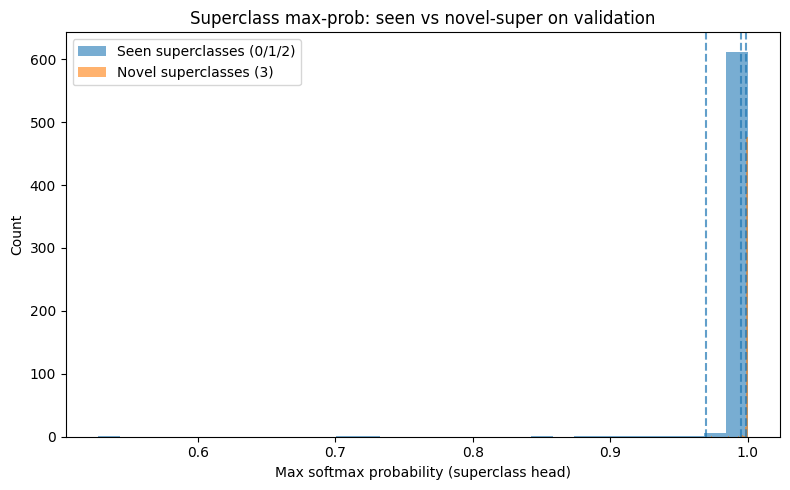

Logged superclass histograms and tau_super candidates to Weights & Biases.

=== Evaluation on val_super_only ===
Overall superclass acc: 0.9787
Seen superclass acc (true super != novel):   0.9618
Seen superclass false-novel rate:            0.0382
Novel superclass acc (true super == novel):  1.0000

=== Evaluation on val_sub_only ===
Overall subclass acc:   0.9309
Seen subclass acc (true sub != novel):       0.8758
Seen subclass false-novel rate:              0.1242
No pseudo_novel_loader available.

=== Evaluation on val ===
Overall superclass acc: 0.9787
Seen superclass acc (true super != novel):   0.9618
Seen superclass false-novel rate:            0.0382
Novel superclass acc (true super == novel):  1.0000

==== Novelty Dashboard ====
     Split   Head                             Metric  \
0   config      -                           APPROACH   
1   config      -                           BACKBONE   
2   config      -                   CIFAR_NOVEL_MODE   
3   config      -           

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
sub_train_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sub_val_acc,▁▆▆▇▇▇▆▇▇█▇▇▇▇▇█▇▇▇█▇█▇▇▇
sub_val_loss,█▃▂▁▁▁▂▁▁▁▂▁▁▂▂▁▁▃▂▂▂▁▂▂▁
tau_super_candidate_1,▁
tau_super_candidate_2,▁
tau_super_candidate_3,▁
val_novel_super_acc,▁
val_overall_sub_acc,▁
val_overall_super_acc,▁
+11,...


In [13]:
if APPROACH == "two_models":
    best_super_path = os.path.join(DATA_ROOT, "best_super_model.pth")
    model_super.load_state_dict(torch.load(best_super_path, map_location=device))
    best_sub_path = os.path.join(DATA_ROOT, "best_sub_model.pth")
    model_sub.load_state_dict(torch.load(best_sub_path, map_location=device))

    analyze_tau_sub(model_sub, pseudo_novel_loader, val_loader, mode="sub_single_head")
    analyze_tau_super(model_super, val_loader, NOVEL_SUPER_IDX, mode="super_single_head")
    evaluate_on_val_with_novelty(
        model_super,
        mode="super_single_head",
        tau_super=TAU_SUPER,
        tau_sub=TAU_SUB,
        val_loader=val_loader,
        name="val_super_only",
    )
    evaluate_on_val_with_novelty(
        model_sub,
        mode="sub_single_head",
        tau_super=TAU_SUPER,
        tau_sub=TAU_SUB,
        val_loader=val_loader,
        name="val_sub_only",
    )

    evaluate_pseudo_novel_sub_with_novelty(model_sub, mode="sub_single_head", tau_sub=TAU_SUB)

    novelty_dashboard(
        model_super,
        val_loader=val_loader,
        pseudo_novel_loader=pseudo_novel_loader,
        mode="super_single_head",
        tau_super=TAU_SUPER,
        tau_sub=TAU_SUB,
        include_pseudo=False,
    )
    novelty_dashboard(
        model_sub,
        val_loader=val_loader,
        pseudo_novel_loader=pseudo_novel_loader,
        mode="sub_single_head",
        tau_super=TAU_SUPER,
        tau_sub=TAU_SUB,
        include_pseudo=True,
    )

    if run_sub is not None:
        run_sub.finish()

else:
    print("APPROACH is not 'two_models'; skipping subclass model training in this cell.")

# SECTION 8: Test-time Inference & CSV Export for leaderboard **(two-head model)**

In [14]:
# SECTION: Test-time inference & CSV export for two-heads model

if APPROACH == "two_heads":
    # Recreate the model and load best checkpoint
    model_two_heads = SharedBackboneTwoHeads(num_super=num_super, num_sub=num_sub).to(device)
    best_ckpt_path = os.path.join(DATA_ROOT, "best_two_heads_kl.pth")
    model_two_heads.load_state_dict(torch.load(best_ckpt_path, map_location=device))

    test_predictions = predict_test_two_heads(
        model_two_heads,
        test_loader,
        tau_super=TAU_SUPER,
        tau_sub=TAU_SUB,
    )
    out_csv_path = os.path.join(DATA_ROOT, "two_heads_predictions.csv")
    test_predictions.to_csv(out_csv_path, index=False)
    print("Saved two-heads predictions (with novelty) to:", out_csv_path)
else:
    print("APPROACH is not 'two_heads'; skipping two-heads inference in this cell.")

APPROACH is not 'two_heads'; skipping two-heads inference in this cell.


# SECTION 9: Test-time Inference & CSV Export for leaderboard **(two separate models)**

In [ ]:
if APPROACH == "two_models":
    model_super.load_state_dict(torch.load(os.path.join(DATA_ROOT, "best_super_model.pth"), map_location=device))
    model_sub.load_state_dict(torch.load(os.path.join(DATA_ROOT, "best_sub_model.pth"), map_location=device))

    test_predictions_two_models = predict_test_two_models(
        model_super,
        model_sub,
        test_loader,
        tau_super=TAU_SUPER,
        tau_sub=TAU_SUB,
    )

    out_csv_path = os.path.join(DATA_ROOT, "two_models_predictions.csv")
    test_predictions_two_models.to_csv(out_csv_path, index=False)
    print("Saved two-model predictions (with novelty) to:", out_csv_path)

else:
    print("APPROACH is not 'two_models'; skipping two-models inference in this cell.")

Saved two-model predictions (with novelty) to: /content/drive/MyDrive/NNDL-Project/Project Data/two_models_predictions.csv
